# EDA (Exploratory Data Analysis) for NLP

The goal of this EDA (as with any EDA, really) is to determine useful information and insights to help us achieve our goal.

I won't get much of your time, so to summarize what I want to do with this project:
- A classification model that takes either a movie name or a synopsis and predicts the correct genre associated with it.
- A summarizer, whose goal is to take a movie script and produce a usable synopsis.



Before diving into the fun part with those models, let's take a look at what we have. For this project, I'll use a portion of the dataset available [here](https://huggingface.co/datasets/adrienheymans/imdb-movie-genres/viewer/default/train?p=542). 

At first, I tried other options like using free APIs (IMDb, OMDb) to retrieve movie names, synopses, genres, directors, actors, etc. But at the end of the day, the best way to get high-quality and abundant data is through Hugging Face (take that with a pinch of salt).

### Disclaimer

- Hugging Face split this dataset into training and test sets. When looking at the initial information, I'll keep in mind to examine both splits.

- I’m only using 2×10k rows from the original datasets because each contains 50k rows—which, as you probably know, is quite demanding in terms of compute power. If it turns out that this number of rows is too low, I’ll increase it later in the notebook.

- I’m also using this project as an opportunity to get familiar with one of pandas’ alternatives, [polars](https://pola.rs/) it's said to be faster and better overall.

- To carry out this EDA, I referred to documentation found online—feel free to check the sources listed in the README file under the *Source* section.

- I've also used generative AI such as ChatGPT, Perplexity, Mistral..

### Front information

If we look at huggingface for information about the dataset let's see what we get ([Here](https://huggingface.co/datasets/adrienheymans/imdb-movie-genres) if you want to see along the file):

```
Dataset Card for "imdb-movie-genres"
MDb (an acronym for Internet Movie Database) is an online database of information related to films, television programs, home videos, video games, and streaming content online – including cast, production crew and personal biographies, plot summaries, trivia, ratings, and fan and critical reviews. An additional fan feature, message boards, was abandoned in February 2017. Originally a fan-operated website, the database is now owned and operated by IMDb.com, Inc., a subsidiary of Amazon.

As of December 2020, IMDb has approximately 7.5 million titles (including episodes) and 10.4 million personalities in its database,[2] as well as 83 million registered users.

IMDb began as a movie database on the Usenet group "rec.arts.movies" in 1990 and moved to the web in 1993.

Provenance : ftp://ftp.fu-berlin.de/pub/misc/movies/database/
```

We see both train and test dataset have 4 features **title, text, genre, labels** now for each features : 
- **title** is of type string and range from 8 to 215 characters 71.1% are 8-29 char long for train split and 47.3% are 21-34 char long for test split. It seems that title are formatted as follow "\<Title\> (\<release year\>)" but for some of them have an additional \\I in the release year or are unknown, I'll have to keep that in mind if I want to extract the release date later.
- **text** is of type string and are filtered by lengths, 89.8% are 41 to 1.09k char long for train split and 85.7% are 37 to 942 char long in test split.
- **genre** is of type string and filtered by classes, there's 27 values 25.1% of genre are drama in both test and train split
- **label** is of type int and range from 0 to 26 (27 values), after going through it seems, as expected, that label are here to link to genre. It will help us gain time.

The dataset is exclusively english, which help us in a way.

Now let's get our hands dirty.

In [1]:
# Import cell
import polars as pl
import nltk
nltk.download('stopwords')

import os
PARENT_FOLDER = globals()['_dh'][0]

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from num2words import num2words
import re
from string import punctuation
!python -m spacy download en_core_web_sm
import spacy
from wordcloud import WordCloud
from collections import Counter
import plotly.graph_objects as go


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\littl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.8 MB 2.2 MB/s eta 0:00:06
     ---- ----------------------------------- 1.6/12.8 MB 3.1 MB/s eta 0:00:04
     ------- -------------------------------- 2.4/12.8 MB 3.2 MB/s eta 0:00:04
     --------- ------------------------------ 3.1/12.8 MB 3.3 MB/s eta 0:00:03
     ------------ --------------------------- 3.9/12.8 MB 3.3 MB/s eta 0:00:03
     ------------- -------------------------- 4.5/12.8 MB 3.2 MB/s eta 0:00:03
     --------------- ------------------------ 5.0/12.8 MB 3.1 MB/s eta 0:00:03
     ----------------- ---------------------- 5.5/12.8 MB 3.1 MB/s eta 0:00:03
     ------------------- -------------------- 6.3/12.8 MB 3.1 MB/s eta 0:00:03
     --------------------- ------------------ 6.8/12.8 MB 3.1 MB/s eta 0:00:02
     ----------------------- ---------------- 7.6/12.8 MB 3.1 MB/s

In [2]:
# Import dataset
TRAIN_FILEPATH = os.path.join(PARENT_FOLDER, "data_exploration","train.csv")
TEST_FILEPATH = os.path.join(PARENT_FOLDER, "data_exploration", "test.csv")
train_df_original = pl.read_csv(TRAIN_FILEPATH)
test_df_original = pl.read_csv(TEST_FILEPATH)

Since for now we're not gonna change anything in the dataset let's make copy later.

In [3]:
print(train_df_original.describe())
print(test_df_original.describe())

shape: (9, 5)
┌────────────┬─────────────────────────────────┬──────────────────────────┬─────────┬──────────┐
│ statistic  ┆ title                           ┆ text                     ┆ genre   ┆ label    │
│ ---        ┆ ---                             ┆ ---                      ┆ ---     ┆ ---      │
│ str        ┆ str                             ┆ str                      ┆ str     ┆ f64      │
╞════════════╪═════════════════════════════════╪══════════════════════════╪═════════╪══════════╡
│ count      ┆ 10000                           ┆ 10000                    ┆ 10000   ┆ 10000.0  │
│ null_count ┆ 0                               ┆ 0                        ┆ 0       ┆ 0.0      │
│ mean       ┆ null                            ┆ null                     ┆ null    ┆ 5.5613   │
│ std        ┆ null                            ┆ null                     ┆ null    ┆ 5.979818 │
│ min        ┆ "1,000 Places to See Before Yo… ┆ " i want to make a       ┆ action  ┆ 0.0      │
│            ┆  

Okay everything seems alright, of course on string feature we wouldn't see much, but we have our 10_000 rows, label is ranged from 0 through 26, and something that seem plausible but a bit curious is there's no null_count. 

Let's check further if there's really no null values.

In [4]:
train_df = train_df_original.clone()
test_df = test_df_original.clone()
# Train df
train_null_count = train_df.select([pl.col(col).is_null().sum().alias(col + "_null_count") for col in train_df.columns])
# Test df
test_null_count = test_df.select([pl.col(col).is_null().sum().alias(col + "_null_count") for col in test_df.columns])

print(train_null_count)
print(test_null_count)

shape: (1, 4)
┌──────────────────┬─────────────────┬──────────────────┬──────────────────┐
│ title_null_count ┆ text_null_count ┆ genre_null_count ┆ label_null_count │
│ ---              ┆ ---             ┆ ---              ┆ ---              │
│ u32              ┆ u32             ┆ u32              ┆ u32              │
╞══════════════════╪═════════════════╪══════════════════╪══════════════════╡
│ 0                ┆ 0               ┆ 0                ┆ 0                │
└──────────────────┴─────────────────┴──────────────────┴──────────────────┘
shape: (1, 4)
┌──────────────────┬─────────────────┬──────────────────┬──────────────────┐
│ title_null_count ┆ text_null_count ┆ genre_null_count ┆ label_null_count │
│ ---              ┆ ---             ┆ ---              ┆ ---              │
│ u32              ┆ u32             ┆ u32              ┆ u32              │
╞══════════════════╪═════════════════╪══════════════════╪══════════════════╡
│ 0                ┆ 0               ┆ 0        

Okay everything seems alright no null values ! Let's pursue.

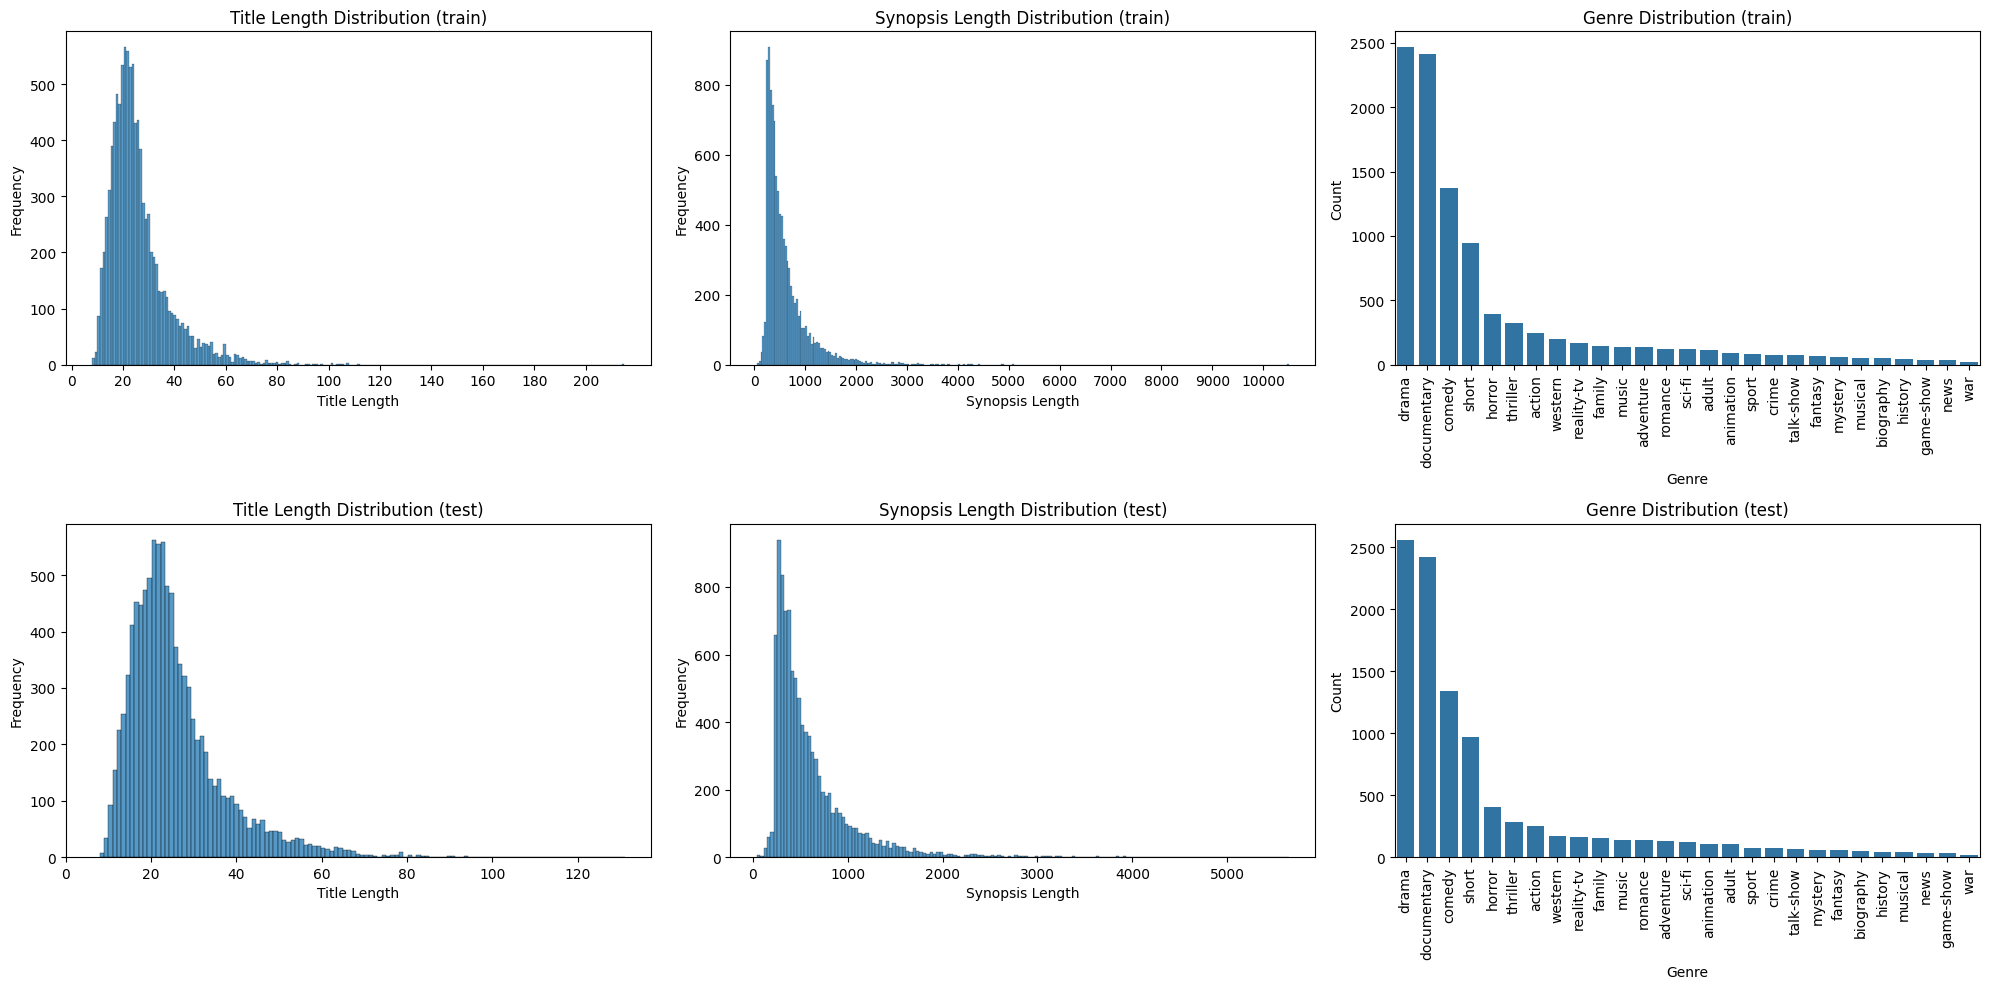

In [5]:
train_df_lengths = train_df.select(
    pl.col("title").str.len_chars().alias("title_length"),
    pl.col("text").str.len_chars().alias("text_length"),
)
train_df_genre_counts = train_df['genre'].value_counts().sort("count", descending=True)


test_df_lengths = test_df.select(
    pl.col("title").str.len_chars().alias("title_length"),
    pl.col("text").str.len_chars().alias("text_length"),
)
test_df_genre_counts = test_df['genre'].value_counts().sort("count", descending=True)

# And now let's plot !

fig, axes = plt.subplots(2,3, figsize=(20,10))

sns.histplot(train_df_lengths['title_length'], ax= axes[0][0])
axes[0][0].set_title("Title Length Distribution (train)")
axes[0][0].set_xlabel("Title Length")
axes[0][0].set_xticks(np.arange(0, max(train_df_lengths['title_length']), 20))
axes[0][0].set_ylabel("Frequency")

sns.histplot(train_df_lengths['text_length'], ax= axes[0][1])
axes[0][1].set_title("Synopsis Length Distribution (train)")
axes[0][1].set_xlabel("Synopsis Length")
axes[0][1].set_xticks(np.arange(0, max(train_df_lengths['text_length']), 1000))
axes[0][1].set_ylabel("Frequency")

sns.barplot(x=train_df_genre_counts['genre'], y=train_df_genre_counts['count'], ax= axes[0][2])
axes[0][2].set_title("Genre Distribution (train)")
axes[0][2].set_xlabel("Genre")
axes[0][2].tick_params(axis='x', rotation=90)
axes[0][2].set_ylabel("Count")

sns.histplot(test_df_lengths['title_length'], ax= axes[1][0])
axes[1][0].set_title("Title Length Distribution (test)")
axes[1][0].set_xlabel("Title Length")
axes[1][0].set_xticks(np.arange(0, max(test_df_lengths['title_length']), 20))
axes[1][0].set_ylabel("Frequency")

sns.histplot(test_df_lengths['text_length'], ax= axes[1][1])
axes[1][1].set_title("Synopsis Length Distribution (test)")
axes[1][1].set_xlabel("Synopsis Length")
axes[1][1].set_xticks(np.arange(0, max(test_df_lengths['text_length']), 1000))
axes[1][1].set_ylabel("Frequency")

sns.barplot(x=test_df_genre_counts['genre'], y=test_df_genre_counts['count'], ax= axes[1][2])
axes[1][2].set_title("Genre Distribution (test)")
axes[1][2].set_xlabel("Genre")
axes[1][2].tick_params(axis='x', rotation=90)
axes[1][2].set_ylabel("Count")


plt.tight_layout()
plt.show()


Okay as we can see both *train* and *test* seems to have the same repartition, with nonetheless some difference on train where there are some row with a greater title length and synopsis length. But Otherwise the genre distribution seems to be, not evenly reparted but still in the same order and proportion in both dataset.

I want to check that in genre we don't have a genre that is classified as "unknown" or something like that, we wouldn't want that in our dataset.

In [6]:

pprint(test_df_genre_counts['genre'].to_list())

['drama',
 'documentary',
 'comedy',
 'short',
 'horror',
 'thriller',
 'action',
 'western',
 'reality-tv',
 'family',
 'music',
 'romance',
 'adventure',
 'sci-fi',
 'animation',
 'adult',
 'sport',
 'crime',
 'talk-show',
 'mystery',
 'fantasy',
 'biography',
 'history',
 'musical',
 'news',
 'game-show',
 'war']


Okay all good on this side.

Let's dig now into the real fun part, **cleaning synopsis**.

### Cleansing & tokenization

Let's see one synopsis to look at how our string is formatted.

In [7]:
pprint(train_df['text'][0])

('listening in to a conversation between his doctor and parents, 10-year-old '
 'oscar learns what nobody has the courage to tell him. he only has a few '
 'weeks to live. furious, he refuses to speak to anyone except '
 'straight-talking rose, the lady in pink he meets on the hospital stairs. as '
 'christmas approaches, rose uses her fantastical experiences as a '
 'professional wrestler, her imagination, wit and charm to allow oscar to live '
 'life and love to the full, in the company of his friends pop corn, einstein, '
 'bacon and childhood sweetheart peggy blue.')


Okay what we can see a lot of surprising things in this synopsis, first there's no capital letter, there's still come punctuations, but what is the most surprising there's no contraction such as "wasn't, didn't, I'll, etc.." which is very rare.

Let's print some more rows and check if it's constant. 

In [8]:
for i in range(1,6):
    print(train_df['text'][i]) # I use print here because pprint sometimes uses simple quote and double quote which can be misleading

a brother and sister with a past incestuous relationship have a current murderous relationship. he murders the women who reject him and she murders the women who get too close to him.
as the bus empties the students for their field trip to the museum of natural history, little does the tour guide suspect that the students are there for more than just another tour. first, during the lecture films, the coeds drift into dreams of the most erotic fantasies one can imagine. after the films, they release the emotion of the fantasies in the most erotic and uncommon ways. one slips off to the curator's office for a little "acquisition. " another finds the anthropologist to see what bones can be identified. even the head teacher isn't immune. soon the tour is over, but as the bus departs, everyone admits it was quite an education.
to help their unemployed father make ends meet, edith and her twin sister grace work as seamstresses . an invalid, grace falls prey to the temptations of chinatown op

Ok so from what we can see still no capital letter, punctuations still present, and there's contraction ! So we add this to our list of processes to apply on our synopses.

Also I want to draw your attention on the fourth line where two dates are displayed **september 11 and halloween of 2001** this indicate us something, we can't remove digits from our synopses, so as a counterpart we want to convert those dates to full plain string, so **september 11** become **september eleven**.

Let's start our cleaning step by step.

In [9]:
# First let's make a copy of our feature 'text' to 'clean_text' this way we will work only on this feature.

train_df = train_df.with_columns(
    pl.col('text').alias('clean_text')
)

test_df = test_df.with_columns(
    pl.col('text').alias('clean_text')
)

# Then let's change digits to str we'll need to build some functions to have a more accurate result

def convert_ordinals(text: str) -> str:
    def ordinal_replacer(match: re.Match):
        number = int(match.group(1))
        return num2words(number, to='ordinal')

    return re.sub(r'\b(\d+)(st|nd|rd|th)\b', ordinal_replacer, text) # Regex : https://regex101.com/r/iyqb2p/1

def convert_cardinals(text: str) -> str:
    def cardinal_replacer(match: re.Match):
        number = int(match.group(1))
        return num2words(number)
    return re.sub(r'(\d+)', cardinal_replacer, text) # Regex capture all number

def convert_all_numbers(text: str) -> str:
    # first convert all ordinals numbers
    text = convert_ordinals(text)
    # And then cardinals
    return convert_cardinals(text)

train_df = train_df.with_columns(
    pl.col('clean_text').map_elements(convert_all_numbers, return_dtype=pl.String).alias("clean_text")
)

test_df = test_df.with_columns(
    pl.col('clean_text').map_elements(convert_all_numbers, return_dtype=pl.String).alias("clean_text")
)

# Let's see if it works


In [10]:
for i in range(1,6):
    print(train_df['clean_text'][i])

a brother and sister with a past incestuous relationship have a current murderous relationship. he murders the women who reject him and she murders the women who get too close to him.
as the bus empties the students for their field trip to the museum of natural history, little does the tour guide suspect that the students are there for more than just another tour. first, during the lecture films, the coeds drift into dreams of the most erotic fantasies one can imagine. after the films, they release the emotion of the fantasies in the most erotic and uncommon ways. one slips off to the curator's office for a little "acquisition. " another finds the anthropologist to see what bones can be identified. even the head teacher isn't immune. soon the tour is over, but as the bus departs, everyone admits it was quite an education.
to help their unemployed father make ends meet, edith and her twin sister grace work as seamstresses . an invalid, grace falls prey to the temptations of chinatown op

In [11]:
# Let's keep going, now that the digit have been taken care of let's remove punctuations and excess whitespace

train_df = train_df.with_columns(
    pl.col('clean_text')
    .str.replace_all(r'[%s]' % re.escape(punctuation), '')
    .str.replace_all(r'\s+', ' ')
    .alias('clean_text')
)

test_df = test_df.with_columns(
    pl.col('clean_text')
    .str.replace_all(r'[%s]' % re.escape(punctuation), '')
    .str.replace_all(r'\s+',' ')
    .alias('clean_text')
)



In [12]:
for i in range(1,6):
    print(train_df['clean_text'][i])

a brother and sister with a past incestuous relationship have a current murderous relationship he murders the women who reject him and she murders the women who get too close to him
as the bus empties the students for their field trip to the museum of natural history little does the tour guide suspect that the students are there for more than just another tour first during the lecture films the coeds drift into dreams of the most erotic fantasies one can imagine after the films they release the emotion of the fantasies in the most erotic and uncommon ways one slips off to the curators office for a little acquisition another finds the anthropologist to see what bones can be identified even the head teacher isnt immune soon the tour is over but as the bus departs everyone admits it was quite an education
to help their unemployed father make ends meet edith and her twin sister grace work as seamstresses an invalid grace falls prey to the temptations of chinatown opium and becomes an addic

Let's tackle one of the big part, removing stopwords, and performing lemmatization.

By experience I'm more familiar and honestly I prefer lemmatization over stemming, I find that we lose too much context with stemming were lemmatization let us keep an overall sense to our content.
Spacy is the best for our situation as it will allow us to perform both actions at the same time.

(as seen in the doc models of spacy [here](https://spacy.io/models) **'en_core_web_sm'** is faster but less accurate whereas **'en_core_web_trf'** if slower but more accurate)

In [13]:
nlp = spacy.load('en_core_web_sm')

def remove_stop_words_and_lemmatize(text: str) -> str:
    return ' '.join(token.lemma_ for token in nlp(text) if not token.is_stop)

train_df = train_df.with_columns(
    pl.col('clean_text')
    .map_elements(remove_stop_words_and_lemmatize, return_dtype=pl.String)
    .alias("clean_text")
)

test_df = test_df.with_columns(
    pl.col('clean_text')
    .map_elements(remove_stop_words_and_lemmatize, return_dtype=pl.String)
    .alias("clean_text")
)


In [14]:
for i in range(1,6):
    print(train_df['clean_text'][i])

brother sister past incestuous relationship current murderous relationship murder woman reject murder woman close
bus empty student field trip museum natural history little tour guide suspect student tour lecture film coed drift dream erotic fantasy imagine film release emotion fantasy erotic uncommon way slip curator office little acquisition find anthropologist bone identify head teacher not immune soon tour bus depart admit education
help unemployed father end meet edith twin sister grace work seamstresse invalid grace fall prey temptation chinatown opium addict condition worsen misguided physician prescribe morphine ease pain father strike oil family enjoy new prosperity sister meet eligible jack herron fellow oil prospector graces shock jack fall love edith jealousy grace tell jack edith drug problem hint sister soon need morphine grace arrange dinner chinatown couple sister jack dance grace slip away opium den edith follow end wrong den arrest ensue drug raid bail jail edith take

Seems to have worked like a charm, great ! As you can see in the cell, it took nearly 10 minutes to process 20k rows so we can guess naïvely that the process of our 100k row might take a good hour.

Now let's use those data to try to perceive impactful information. 

For this part since I want us to be able to see clearly information on each part of the dataset I will do every vizualisation three times, one for train, another for test, and finally for both of them together, I know I could use subplot but it would decrease the readability of wordcloud which, in my opinion, is already a bit difficult to read.

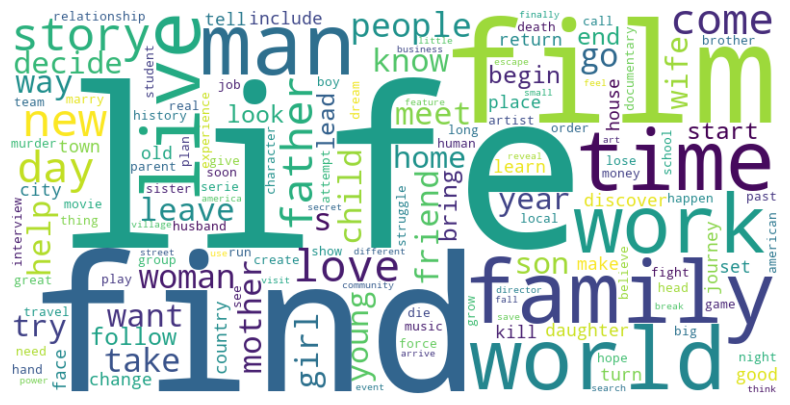

In [15]:
# Word cloud for train

train_whole_text = ' '.join(train_df['clean_text'])

train_wordcloud = WordCloud(width=800, height=400,max_words=150,background_color='white').generate(train_whole_text)
plt.figure(figsize=(10,5))
plt.imshow(train_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



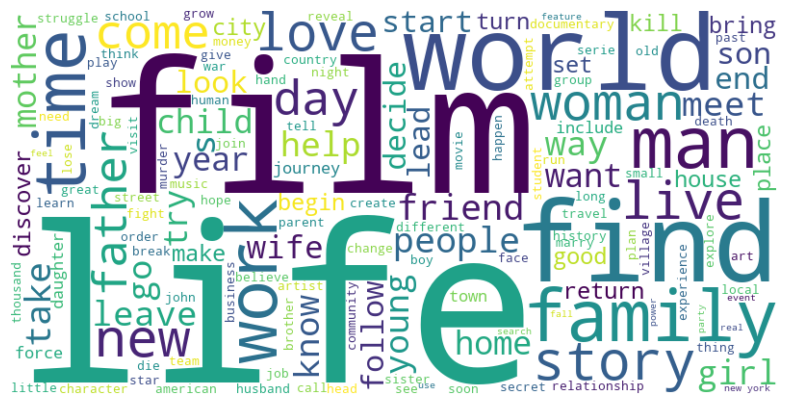

In [16]:
# Word cloud for test

test_whole_text = ' '.join(test_df['clean_text'])

test_wordcloud = WordCloud(width=800, height=400,max_words=150,background_color='white').generate(test_whole_text)
plt.figure(figsize=(10,5))
plt.imshow(test_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

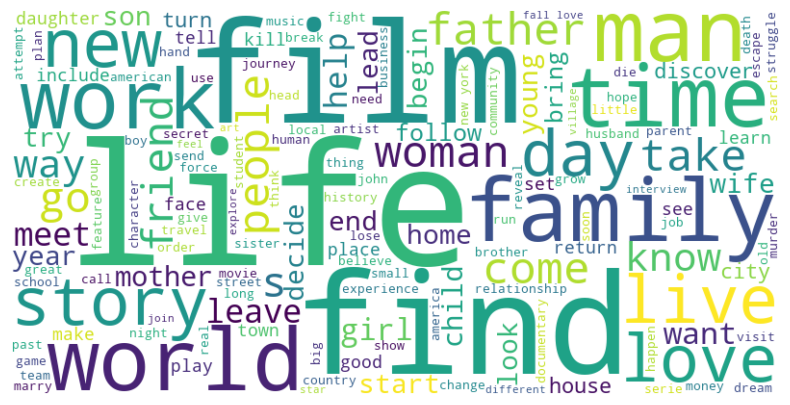

In [17]:
# And now both of them

whole_text = test_whole_text + " " + train_whole_text
whole_wordcloud = WordCloud(width=800, height=400,max_words=150,background_color='white').generate(whole_text)
plt.figure(figsize=(10,5))
plt.imshow(whole_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Okay everythings seem's fine, we got the approximately same result over the datasets.

What I would like to see now is the top X-ish word per genres. I'll use plotly for that, I want to make a interactive viz, where it display the top 5 words and count, and also allow you to select the genre.

In [18]:
train_df_by_genres = (
    train_df
    .group_by("genre")
    .agg(
        pl.col("clean_text").alias("texts")  # Aggregate as list
    )
    .with_columns(
        pl.col("texts").list.join(" ").alias("joined_text")
    )
)

# Then we count the frequency of each word by genre

rows = []

for genre, text in zip(train_df_by_genres['genre'], train_df_by_genres['joined_text']):
    words = text.split()
    word_counts = Counter(words).most_common(5)
    for word, count in word_counts:
        rows.append({"genre": genre, "word": word, "count": count})

# remake a polars dataframe

train_top_words = pl.DataFrame(rows)

# and finally make the visualization

genres = train_top_words['genre'].unique()
fig = go.Figure()

for genre in genres:
    df_genre = train_top_words.filter(pl.col('genre') == genre)
    fig.add_trace(
        go.Bar(
            x=df_genre['word'],
            y=df_genre['count'],
            name=genre,
            visible=(genre == genre[0])
        )
    )

fig.update_layout(
    updatemenus=[
        {
            "buttons" : [
                {
                    "label": genre,
                    "method": "update",
                    "args" : [
                        {"visible": [g==genre for g in genres]},
                        {"title": f"Top 5 Words in {genre}"}
                    ]
                }
                for genre in genres
            ],
            "direction": "down",
            "showactive": True
        }
    ],
    title=f"Top 5 Words in {genres[0]}",
    xaxis_title="Word",
    yaxis_title="Frequency"
)

fig.show()

In [19]:
test_df_by_genres = (
    test_df
    .group_by("genre")
    .agg(
        pl.col("clean_text").alias("texts")  # Aggregate as list
    )
    .with_columns(
        pl.col("texts").list.join(" ").alias("joined_text")
    )
)
rows = []
for genre, text in zip(test_df_by_genres['genre'], test_df_by_genres['joined_text']):
    words = text.split()
    word_counts = Counter(words).most_common(5)
    for word, count in word_counts:
        rows.append({"genre": genre, "word": word, "count": count})
test_top_words = pl.DataFrame(rows)
genres = test_top_words['genre'].unique()
fig = go.Figure()
for genre in genres:
    df_genre = test_top_words.filter(pl.col('genre') == genre)
    fig.add_trace(
        go.Bar(
            x=df_genre['word'],
            y=df_genre['count'],
            name=genre,
            visible=(genre == genre[0])
        )
    )
fig.update_layout(
    updatemenus=[
        {
            "buttons" : [
                {
                    "label": genre,
                    "method": "update",
                    "args" : [
                        {"visible": [g==genre for g in genres]},
                        {"title": f"Top 5 Words in {genre}"}
                    ]
                }
                for genre in genres
            ],
            "direction": "down",
            "showactive": True
        }
    ],
    title=f"Top 5 Words in {genres[0]}",
    xaxis_title="Word",
    yaxis_title="Frequency"
)

fig.show()

Those graphics will help us later to evaluate our model. What I mean by that is if we look at drama which is the most present genre in the dataset, the word **"life young** and **love"** are the most present word, but what happen if we try to create a horror movie synopsis with those words and words from the horror genre ?

This will not be answered here since the purpose of this notebook is only to present how we did the analysis. 

We're not gonna do much more data vizualisation, because whereas in the example provided by the documentation (README) where most of them are trying to classify review for different amazon products so we've like a tree for each product we're not in this case.
Nonetheless those data viz will help us greatly to trick and test our models.